# Alphalens Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
import pandas as pd
from alphalens.tears import create_summary_tear_sheet, create_full_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

In [3]:
idx = pd.IndexSlice

## Load Data

In [38]:
with pd.HDFStore('data.h5') as store:
    lr_predictions = store['lr/predictions']
    lasso_predictions = store['lasso/predictions']
    lasso_scores = store['lasso/scores']
    ridge_predictions = store['ridge/predictions']
    ridge_scores = store['ridge/scores']

In [5]:
DATA_STORE = Path('..', 'data', 'assets.h5')

In [6]:
def get_trade_prices(tickers, start, stop):
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    prices = prices.loc[idx[tickers, str(start):str(stop)], 'adj_open']
    return (prices
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [37]:
def get_best_alpha(scores):
    return scores.groupby('alpha').ic.mean().idxmax()

In [8]:
def get_factor(predictions):
    return (predictions.unstack('symbol')
            .dropna(how='all')
            .stack()
            .tz_localize('UTC', level='date')
            .sort_index())    

## Linear Regression

In [9]:
lr_factor = get_factor(lr_predictions.predicted.swaplevel())
lr_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.002619
                           AAPL     -0.001722
                           ABBV      0.001177
                           AGN       0.001837
                           AIG      -0.000101
dtype: float64

In [10]:
tickers = lr_factor.index.get_level_values('symbol').unique()

In [11]:
trade_prices = get_trade_prices(tickers, 2014, 2017)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2014-01-02 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 253 entries, AAL to ZTS
dtypes: float64(253)
memory usage: 2.0 MB


In [12]:
lr_factor_data = get_clean_factor_and_forward_returns(factor=lr_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))
lr_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74044 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74044 non-null  float64
 1   5D               74044 non-null  float64
 2   10D              74044 non-null  float64
 3   21D              74044 non-null  float64
 4   factor           74044 non-null  float64
 5   factor_quantile  74044 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.038517,0.009524,-0.003000,0.003995,14982,20.233915
2,-0.015944,0.011669,-0.000896,0.003328,14868,20.079952
3,-0.013009,0.013479,0.000203,0.003336,14344,19.372265
4,-0.011726,0.015676,0.001257,0.003449,14868,20.079952
5,-0.010147,0.037777,0.003308,0.004298,14982,20.233915


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.041,0.039,0.029,0.010
beta,-0.008,-0.083,-0.062,0.030
Mean Period Wise Return Top Quantile (bps),1.335,1.205,0.431,0.413
Mean Period Wise Return Bottom Quantile (bps),-1.842,-0.789,-0.640,-0.585
Mean Period Wise Spread (bps),3.178,2.017,1.086,0.983


Information Analysis


,1D,5D,10D,21D
IC Mean,0.020,0.017,0.016,0.013
IC Std.,0.180,0.168,0.166,0.160
Risk-Adjusted IC,0.110,0.102,0.099,0.082
t-stat(IC),3.013,2.790,2.702,2.252
p-value(IC),0.003,0.005,0.007,0.025
IC Skew,-0.025,-0.098,-0.133,-0.089
IC Kurtosis,-0.173,-0.113,-0.134,-0.335


ValueError: freq must be Day, BDay or CustomBusinessDay

<Figure size 432x288 with 0 Axes>

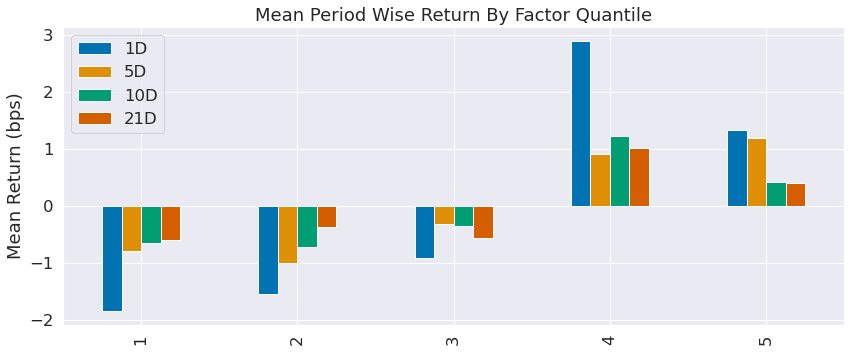

In [13]:
create_summary_tear_sheet(lr_factor_data);

## Ridge Regression

In [39]:
best_ridge_alpha = get_best_alpha(ridge_scores)
ridge_predictions = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha].drop('alpha', axis=1)

In [40]:
ridge_factor = get_factor(ridge_predictions.predicted.swaplevel())
ridge_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.002618
                           AAPL     -0.001643
                           ABBV      0.000983
                           AGN       0.001629
                           AIG      -0.000260
dtype: float64

In [41]:
ridge_factor_data = get_clean_factor_and_forward_returns(factor=ridge_factor,
                                                         prices=trade_prices,
                                                         quantiles=5,
                                                         periods=(1, 5, 10, 21))
ridge_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74044 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74044 non-null  float64
 1   5D               74044 non-null  float64
 2   10D              74044 non-null  float64
 3   21D              74044 non-null  float64
 4   factor           74044 non-null  float64
 5   factor_quantile  74044 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.034112,0.010091,-0.003245,0.003606,14982,20.233915
2,-0.013664,0.012116,-0.001271,0.003064,14868,20.079952
3,-0.010536,0.013603,-0.000231,0.003109,14344,19.372265
4,-0.009468,0.016201,0.000766,0.003243,14868,20.079952
5,-0.008161,0.034475,0.002685,0.004088,14982,20.233915


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.039,0.039,0.031,0.011
beta,-0.006,-0.086,-0.067,0.032
Mean Period Wise Return Top Quantile (bps),1.589,1.328,0.640,0.370
Mean Period Wise Return Bottom Quantile (bps),-1.965,-1.041,-0.836,-0.688
Mean Period Wise Spread (bps),3.554,2.392,1.492,1.041


Information Analysis


,1D,5D,10D,21D
IC Mean,0.020,0.017,0.017,0.013
IC Std.,0.180,0.169,0.168,0.161
Risk-Adjusted IC,0.109,0.102,0.098,0.078
t-stat(IC),2.972,2.801,2.693,2.125
p-value(IC),0.003,0.005,0.007,0.034
IC Skew,-0.040,-0.092,-0.136,-0.099
IC Kurtosis,-0.181,-0.122,-0.156,-0.326


ValueError: freq must be Day, BDay or CustomBusinessDay

<Figure size 432x288 with 0 Axes>

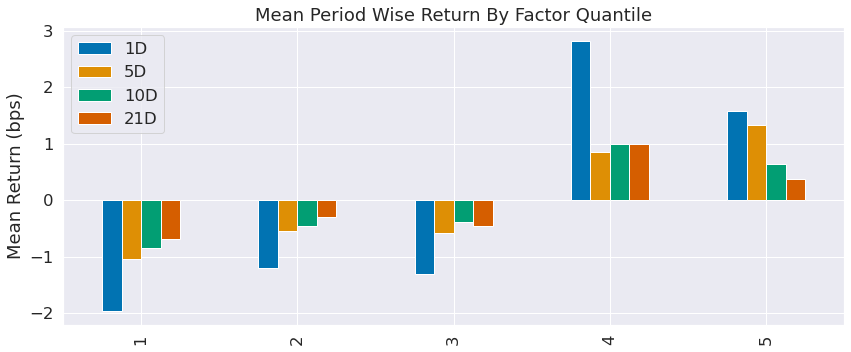

In [42]:
create_summary_tear_sheet(ridge_factor_data);

## Lasso Regression

In [43]:
best_lasso_alpha = get_best_alpha(lasso_scores)
lasso_predictions = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha].drop('alpha', axis=1)

In [44]:
lasso_factor = get_factor(lasso_predictions.predicted.swaplevel())
lasso_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.002656
                           AAPL     -0.001791
                           ABBV      0.001055
                           AGN       0.001626
                           AIG      -0.000264
dtype: float64

In [45]:
lasso_factor_data = get_clean_factor_and_forward_returns(factor=lasso_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))
lasso_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74044 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74044 non-null  float64
 1   5D               74044 non-null  float64
 2   10D              74044 non-null  float64
 3   21D              74044 non-null  float64
 4   factor           74044 non-null  float64
 5   factor_quantile  74044 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.036170,0.010118,-0.003320,0.003764,14982,20.233915
2,-0.014207,0.012300,-0.001287,0.003217,14868,20.079952
3,-0.011925,0.013981,-0.000216,0.003293,14344,19.372265
4,-0.010588,0.016376,0.000807,0.003446,14868,20.079952
5,-0.008742,0.037712,0.002798,0.004375,14982,20.233915


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.041,0.039,0.030,0.010
beta,-0.007,-0.084,-0.062,0.033
Mean Period Wise Return Top Quantile (bps),1.779,1.297,0.576,0.456
Mean Period Wise Return Bottom Quantile (bps),-1.618,-0.857,-0.705,-0.589
Mean Period Wise Spread (bps),3.396,2.177,1.296,1.024


Information Analysis


,1D,5D,10D,21D
IC Mean,0.020,0.017,0.016,0.013
IC Std.,0.180,0.168,0.168,0.160
Risk-Adjusted IC,0.110,0.101,0.097,0.081
t-stat(IC),2.999,2.780,2.659,2.228
p-value(IC),0.003,0.006,0.008,0.026
IC Skew,-0.030,-0.094,-0.130,-0.095
IC Kurtosis,-0.175,-0.097,-0.149,-0.340


ValueError: freq must be Day, BDay or CustomBusinessDay

<Figure size 432x288 with 0 Axes>

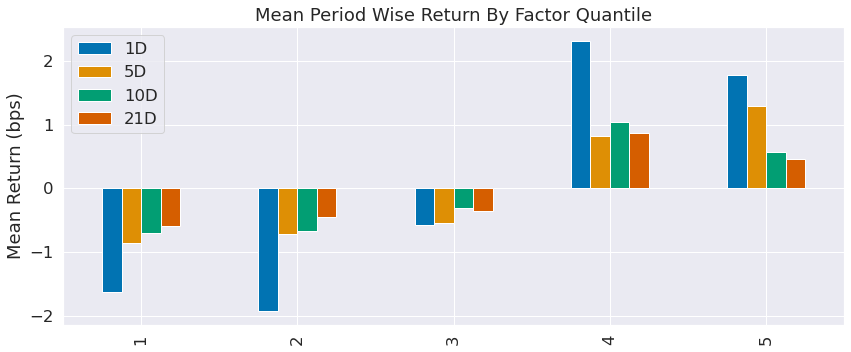

In [46]:
create_summary_tear_sheet(lasso_factor_data);